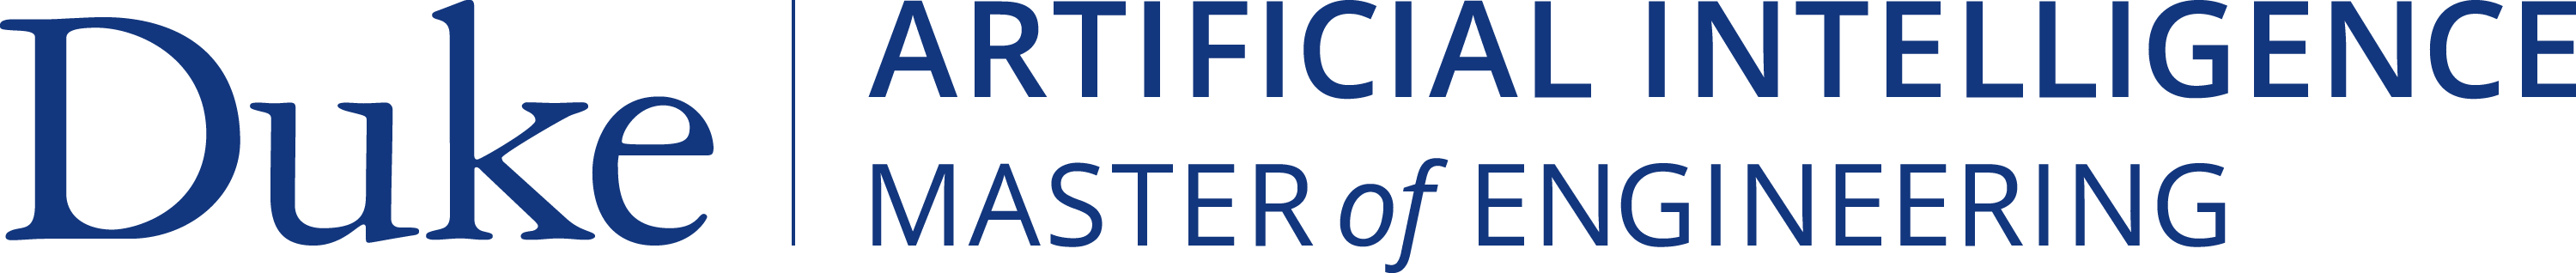


# AIPI 590 Applied Computer Vision
## Project 2 - Object Detection
- Keese Phillips

# Attribution:
[Modern-Computer-Vision-with-PyTorch](https://github.com/PacktPublishing/Modern-Computer-Vision-with-PyTorch)


[![Open In Collab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/keesephillips/applied_computer_vision_project_2/blob/main/model.ipynb)

In [ ]:
import os

# Remove Colab default sample_data
!rm -r ./sample_data

# Clone GitHub files to colab workspace
repo_name = "applied_computer_vision_project_2"
git_path = 'https://github.com/keesephillips/applied_computer_vision_project_2'
!git clone "{git_path}"

# Install dependencies from requirements.txt file
!pip install -r "{os.path.join(repo_name,'requirements.txt')}"

notebook_dir = 'applied_computer_vision_project_2'
path_to_notebook = os.path.join(repo_name,notebook_dir)
%cd "{path_to_notebook}"
%ls

In [ ]:
import os
import json
import cv2
import time
import torch
import torchvision
import shutil
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.patches as patches
from PIL import Image
from torch.utils.data import DataLoader, Dataset, random_split
from torchinfo import summary
from torchvision import transforms, models, datasets
from torchvision.ops import nms
from torchvision.transforms import functional as F
from torch_snippets.torch_loader import Report
from ultralytics import YOLO
from sklearn.model_selection import train_test_split


device = 'cuda' if torch.cuda.is_available() else 'cpu'

In [4]:
class_mapping = {'laptop': 0, 'book': 1, 'background': 2}
reverse_mapping = {0: 'laptop', 1: 'book', 2: 'background'}

def collate_fn(batch):
    images, targets = zip(*batch)
    return list(images), list(targets)

def preprocess_image(img):
    img = img.permute(0, 2, 1)
    return img.to(device).float()

class LaptopUtensils(Dataset):
    def __init__(self, annotation_folder, transform):
        self.annotation_folder = annotation_folder
        self.image_files = []
        self.annotation_files = []

        for root, _, files in os.walk(annotation_folder):
            for file in files:
                if file.lower().endswith('.json'):
                    with open(os.path.join(root, file), 'r') as f:
                        data = json.load(f)
                        self.image_files.append(data['imagePath'])
                        self.annotation_files.append(file)

        self.normalize = transform

    def __len__(self):
        return len(self.image_files)

    def __getitem__(self, ix):
        image_file = self.image_files[ix]
        annotation_file = os.path.join(self.annotation_folder, self.annotation_files[ix])
        image_path = os.path.join(self.annotation_folder, image_file.replace('\\', '/'))
        img = Image.open(image_path).convert('RGB')

        img = self.normalize(img)
        h, w = img.shape[-2:]
        img = preprocess_image(img)

        boxes = []
        labels = []

        if os.path.exists(annotation_file):
            with open(annotation_file, 'r') as f:
                data = json.load(f)
                img_width = data['imageWidth']
                img_height = data['imageHeight']

                for shape in data['shapes']:
                    class_id = class_mapping[shape['label']]
                    x_1, y_1 = shape['points'][0]
                    x_2, y_2 = shape['points'][1]

                    # labelme does not always place the x_min in the 1st position
                    # depending on how the rectangle is drawn
                    x_min = np.min(np.array([x_1, x_2]))
                    x_max = np.max(np.array([x_1, x_2]))
                    y_min = np.min(np.array([y_1, y_2]))
                    y_max = np.max(np.array([y_1, y_2]))

                    # Normalize coordinates
                    x_min /= img_width
                    y_min /= img_height
                    x_max /= img_width
                    y_max /= img_height

                    # Convert to pixel coordinates
                    x_min = int(x_min * w)
                    y_min = int(y_min * h)
                    x_max = int(x_max * w)
                    y_max = int(y_max * h)

                    boxes.append([x_min, y_min, x_max, y_max])
                    labels.append(class_id)

        target = {}
        target["boxes"] = torch.tensor(boxes, dtype=torch.float32)
        target["labels"] = torch.tensor(labels, dtype=torch.int64)

        return img, target


In [31]:
def display_image(image, boxes, classes):
  fig, ax = plt.subplots(1)

  ax.imshow(image.transpose(2, 1, 0))
  ax.axis('off')
  for i in range(len(boxes)):
    bbox = patches.Rectangle((boxes[i][0], boxes[i][1]), boxes[i][2] - boxes[i][0], boxes[i][3] - boxes[i][1], linewidth=2, edgecolor='r', facecolor='none')
    plt.text(boxes[i][0], boxes[i][1] - 10, reverse_mapping[classes[i]], color='red', fontsize=12, weight='light')
    ax.add_patch(bbox)

  plt.show()

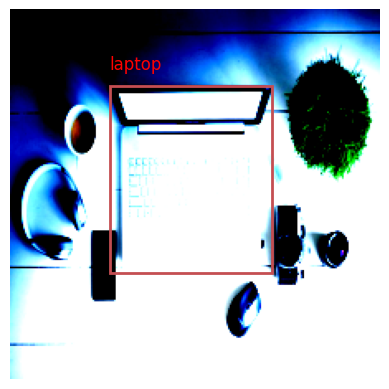

In [32]:
IMAGE_ROOT = 'applied_computer_vision_project_2/images'
ANNOTATION_ROOT = 'applied_computer_vision_project_2/annotations'

transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

dataset = LaptopUtensils(annotation_folder=ANNOTATION_ROOT, transform=transform)
image, target = dataset[0]
display_image(image.cpu().detach().numpy(), target['boxes'].cpu().detach().numpy(), target['labels'].cpu().detach().numpy())

In [7]:
test_ratio = 0.2
train_ratio = 1 - test_ratio

train_size = int(len(dataset) * train_ratio)
test_size = len(dataset) - train_size

generator = torch.Generator().manual_seed(42)
train_dataset, test_dataset = random_split(dataset, [train_size, test_size], generator)

print(f"Training set size: {len(train_dataset)}")
print(f"Testing set size: {len(test_dataset)}")

Training set size: 169
Testing set size: 43


In [8]:
batch_size = 4

train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, collate_fn=collate_fn, num_workers=0)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False, collate_fn=collate_fn, num_workers=0)

In [9]:
from torchvision.models.detection.faster_rcnn import FastRCNNPredictor
from torchmetrics.detection import MeanAveragePrecision

num_classes = len(class_mapping)

def get_model():
    model = torchvision.models.detection.fasterrcnn_resnet50_fpn(pretrained=True)
    in_features = model.roi_heads.box_predictor.cls_score.in_features
    model.roi_heads.box_predictor = FastRCNNPredictor(in_features, num_classes)
    return model

In [10]:
# Defining training and validation functions for a single batch
def train_batch(inputs, model, optimizer):
    model.train()
    input, targets = inputs
    input = list(image.to(device) for image in input)
    targets = [{k: v.to(device) for k, v in t.items()} for t in targets]
    optimizer.zero_grad()
    losses = model(input, targets)
    loss = sum(loss for loss in losses.values())
    loss.backward()
    optimizer.step()
    return loss, losses

@torch.no_grad() # this will disable gradient computation in the function below
def validate_batch(inputs, model):
    model.train() # to obtain the losses, model needs to be in train mode only. # #Note that here we are not defining the model's forward method
#and hence need to work per the way the model class is defined
    input, targets = inputs
    input = list(image.to(device) for image in input)
    targets = [{k: v.to(device) for k, v in t.items()} for t in targets]

    optimizer.zero_grad()
    losses = model(input, targets)
    loss = sum(loss for loss in losses.values())
    return loss, losses

def profile_model(model, input_data, isYolo=True, num_iterations=100):
    torch.cuda.reset_peak_memory_stats()

    if not isYolo:
      model.eval()

    with torch.no_grad():
        _ = model(input_data)

        start_time = time.time()
        for _ in range(num_iterations):
            _ = model(input_data)
        end_time = time.time()

    avg_time = (end_time - start_time) / num_iterations
    max_memory = torch.cuda.max_memory_allocated() / 1024**2

    return avg_time, max_memory

In [ ]:
model = get_model().to(device)
optimizer = torch.optim.SGD(model.parameters(), lr=0.0001, momentum=0.9, weight_decay=0.00005)

n_epochs = 50
log = Report(n_epochs)

torch.onnx.export(model, torch.zeros(1,3,224,224).to(device), "faster_rcnn_model.onnx")

In [12]:
for epoch in range(n_epochs):
    _n = len(train_loader)
    for ix, inputs in enumerate(train_loader):
        images, targets = inputs
        loss, losses = train_batch((images, targets), model, optimizer)
        loc_loss, regr_loss, loss_objectness, loss_rpn_box_reg = \
            [losses[k] for k in ['loss_classifier', 'loss_box_reg', 'loss_objectness', 'loss_rpn_box_reg']]
        pos = (epoch + (ix + 1) / _n)
        log.record(pos, trn_loss=loss.item(), trn_loc_loss=loc_loss.item(),
                   trn_regr_loss=regr_loss.item(), trn_objectness_loss=loss_objectness.item(),
                   trn_rpn_box_reg_loss=loss_rpn_box_reg.item(), end='\r')

    _n = len(test_loader)
    for ix, inputs in enumerate(test_loader):
        images, targets = inputs
        loss, losses = validate_batch((images, targets), model)
        loc_loss, regr_loss, loss_objectness, loss_rpn_box_reg = \
            [losses[k] for k in ['loss_classifier', 'loss_box_reg', 'loss_objectness', 'loss_rpn_box_reg']]
        pos = (epoch + (ix + 1) / _n)
        log.record(pos, val_loss=loss.item(), val_loc_loss=loc_loss.item(),
                   val_regr_loss=regr_loss.item(), val_objectness_loss=loss_objectness.item(),
                   val_rpn_box_reg_loss=loss_rpn_box_reg.item(), end='\r')
    if (epoch + 1) % (n_epochs // 5) == 0:
        log.report_avgs(epoch + 1)


EPOCH: 10.000  trn_regr_loss: 0.042  trn_loss: 0.112  val_regr_loss: 0.058  val_objectness_loss: 0.028  trn_loc_loss: 0.044  trn_objectness_loss: 0.019  val_loc_loss: 0.048  val_rpn_box_reg_loss: 0.007  trn_rpn_box_reg_loss: 0.007  val_loss: 0.141  (383.29s - 1533.18s remaining)
EPOCH: 20.000  trn_regr_loss: 0.041  trn_loss: 0.106  val_regr_loss: 0.059  val_objectness_loss: 0.028  trn_loc_loss: 0.043  trn_objectness_loss: 0.015  val_loc_loss: 0.048  val_rpn_box_reg_loss: 0.007  trn_rpn_box_reg_loss: 0.007  val_loss: 0.141  (760.44s - 1140.67s remaining)
EPOCH: 30.000  trn_regr_loss: 0.043  trn_loss: 0.107  val_regr_loss: 0.055  val_objectness_loss: 0.026  trn_loc_loss: 0.044  trn_objectness_loss: 0.014  val_loc_loss: 0.045  val_rpn_box_reg_loss: 0.006  trn_rpn_box_reg_loss: 0.006  val_loss: 0.132  (1136.11s - 757.41s remaining)
EPOCH: 40.000  trn_regr_loss: 0.042  trn_loss: 0.098  val_regr_loss: 0.053  val_objectness_loss: 0.025  trn_loc_loss: 0.040  trn_objectness_loss: 0.010  val_loc

In [13]:
metric = MeanAveragePrecision()
model.eval()

with torch.no_grad():
  for ix, inputs in enumerate(test_loader):
        images, targets = inputs
        input = list(image.to(device) for image in images)
        targets = [{k: v.to(device) for k, v in t.items()} for t in targets]

        predictions = model(input)
        metric.update(predictions, targets)

result = metric.compute()

print(f"mAP: {result['map']}")
print(f"mAP@50: {result['map_50']}")
print(f"mAP@75: {result['map_75']}")

mAP: 0.0528600849211216
mAP@50: 0.16578534245491028
mAP@75: 0.01544011291116476


In [14]:
for ix, (images, targets) in enumerate(test_loader):
    if ix==1: break
    images = [im for im in images]

    avg_time, max_memory = profile_model(model, [images[0]], isYolo=False)
    print(f"Average inference time: {avg_time*1000:.2f} ms")
    print(f"Max GPU memory allocated: {max_memory:.2f} MB")

Average inference time: 84.24 ms
Max GPU memory allocated: 651.66 MB


100%|██████████| 151/151 [00:00<00:00, 2166.29it/s]


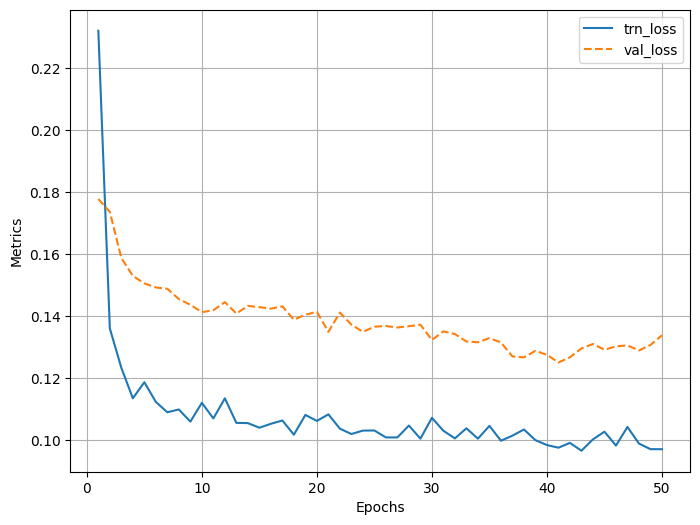

In [15]:
log.plot_epochs(['trn_loss','val_loss'])

In [16]:
torch.save(model, 'faster_rcnn_model.pt')

In [17]:
def decode_output(output):
    bbs = output['boxes'].cpu().detach().numpy().astype(np.uint16)
    labels = output['labels'].cpu().detach().numpy()
    confs = output['scores'].cpu().detach().numpy()
    ixs = nms(torch.tensor(bbs.astype(np.float32)), torch.tensor(confs), 0.05)
    bbs, confs, labels = [tensor[ixs] for tensor in [bbs, confs, labels]]

    if len(ixs) == 1:
        bbs, confs, labels = [np.array([tensor]) for tensor in [bbs, confs, labels]]
    return bbs.tolist(), confs.tolist(), labels.tolist()

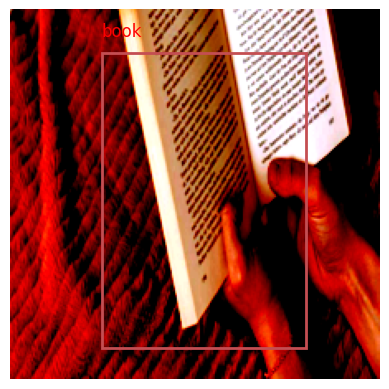

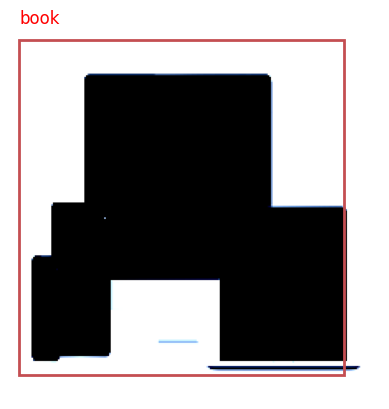

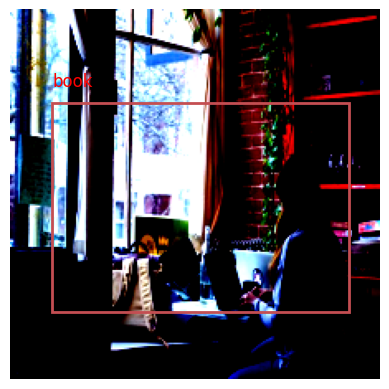

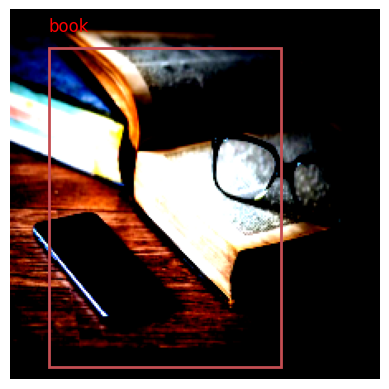

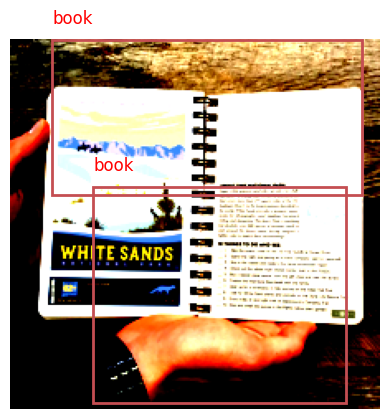

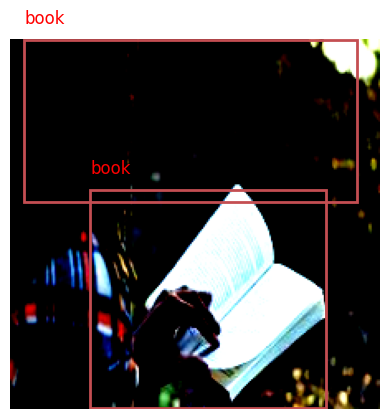

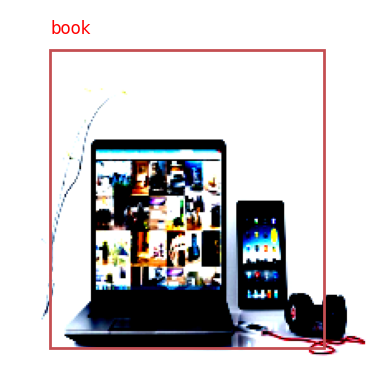

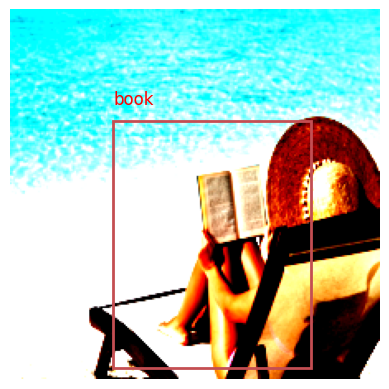

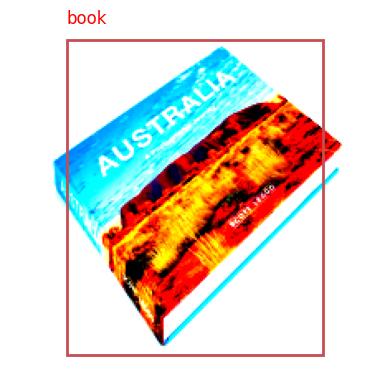

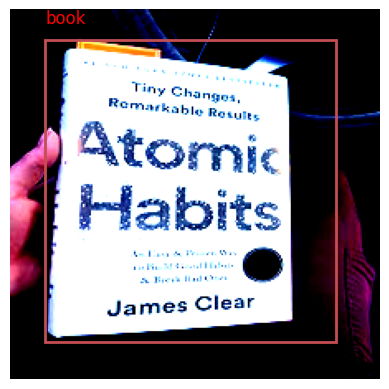

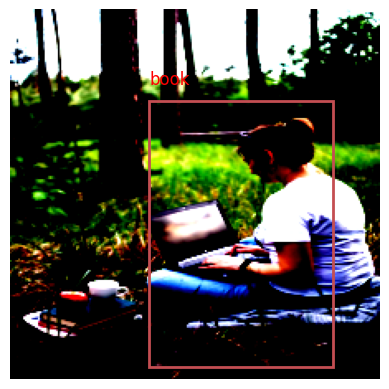

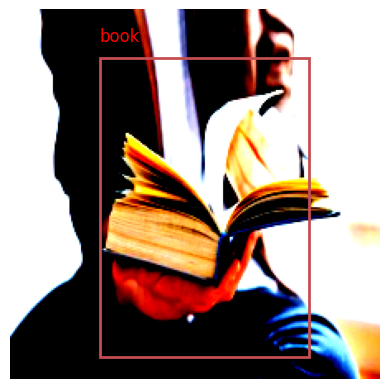

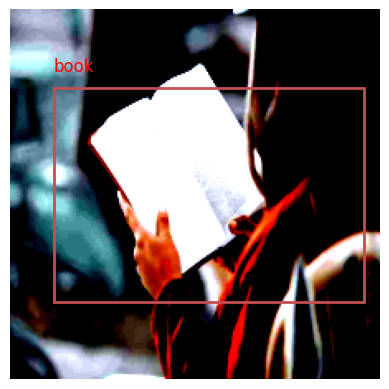

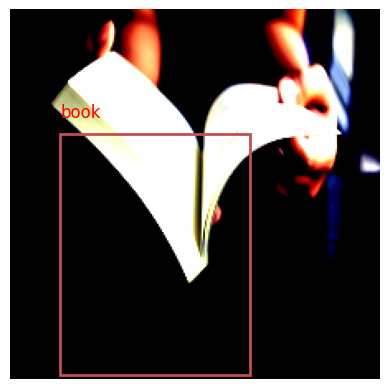

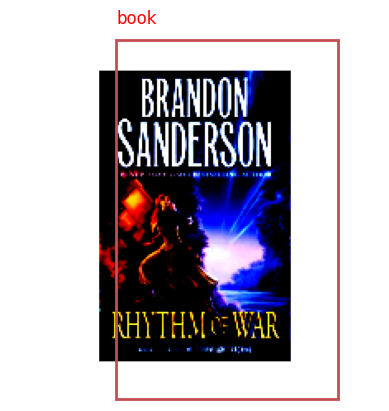

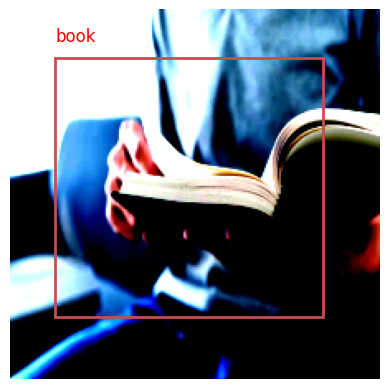

In [36]:
model.eval()
for ix, (images, targets) in enumerate(test_loader):
    if ix==4: break
    images = [im for im in images]
    outputs = model(images)
    for ix, output in enumerate(outputs):
        bbs, confs, labels = decode_output(output)
        display_image(images[ix].cpu().numpy(), bbs, labels)


In [ ]:
image_root = os.getcwd() + '/applied_computer_vision_project_2/images'  
annotation_root = os.getcwd() + '/applied_computer_vision_project_2/annotations' 
output_root = os.getcwd() + '/applied_computer_vision_project_2/dataset'  


os.makedirs(os.path.join(output_root, 'train/images'), exist_ok=True)
os.makedirs(os.path.join(output_root, 'val/images'), exist_ok=True)
os.makedirs(os.path.join(output_root, 'train/labels'), exist_ok=True)
os.makedirs(os.path.join(output_root, 'val/labels'), exist_ok=True)

image_paths = []
for label_folder in os.listdir(image_root):
    label_folder_path = os.path.join(image_root, label_folder)
    if os.path.isdir(label_folder_path):
        for image_file in os.listdir(label_folder_path):
            if image_file.lower().endswith(('.png', '.jpg', '.jpeg')):
                image_paths.append((os.path.join(label_folder_path, image_file), label_folder))

train_images, val_images = train_test_split(image_paths, test_size=0.2, random_state=42)

def convert_annotation(annotation_path, img_width, img_height):
    with open(annotation_path, 'r') as f:
        data = json.load(f)

    yolo_annotations = []
    for shape in data['shapes']:
        class_id = class_mapping[shape['label']]
        x_min, y_min = shape['points'][0]
        x_max, y_max = shape['points'][1]

        # Calculate YOLO format values
        x_center = abs(x_min + x_max) / 2.0 / img_width
        y_center = abs(y_min + y_max) / 2.0 / img_height
        width = abs(x_max - x_min) / img_width
        height = abs(y_max - y_min) / img_height

        yolo_annotations.append(f"{class_id} {x_center} {y_center} {width} {height}")

    return yolo_annotations

def copy_and_convert_files(image_list, split):
    for image_path, label in image_list:
        image_name = os.path.basename(image_path)
        annotation_name = os.path.splitext(image_name)[0] + '.json'
        annotation_path = os.path.join(annotation_root, annotation_name)

        if os.path.exists(annotation_path):
            shutil.copy(image_path, os.path.join(output_root, f'{split}/images', image_name))

            img = Image.open(image_path)
            img_width, img_height = img.size
            yolo_annotations = convert_annotation(annotation_path, img_width, img_height)

            yolo_annotation_path = os.path.join(output_root, f'{split}/labels', os.path.splitext(image_name)[0] + '.txt')
            with open(yolo_annotation_path, 'w') as f:
                f.write('\n'.join(yolo_annotations))

copy_and_convert_files(train_images, 'train')
copy_and_convert_files(val_images, 'val')

In [21]:
model = YOLO('yolov8l.pt')

In [22]:
results = model.train(
    data='applied_computer_vision_project_2/config.yaml',
    epochs=100,
    imgsz=640,
    batch=4,
    name='yolov8l_custom',
    device=device
)

New https://pypi.org/project/ultralytics/8.3.19 available 😃 Update with 'pip install -U ultralytics'
Ultralytics 8.3.18 🚀 Python-3.10.12 torch-2.4.1+cu121 CUDA:0 (Tesla T4, 15102MiB)
engine/trainer: task=detect, mode=train, model=yolov8l.pt, data=applied_computer_vision_project_2/config.yaml, epochs=100, time=None, patience=100, batch=4, imgsz=640, save=True, save_period=-1, cache=False, device=cuda, workers=8, project=None, name=yolov8l_custom4, exist_ok=False, pretrained=True, optimizer=auto, verbose=True, seed=0, deterministic=True, single_cls=False, rect=False, cos_lr=False, close_mosaic=10, resume=False, amp=True, fraction=1.0, profile=False, freeze=None, multi_scale=False, overlap_mask=True, mask_ratio=4, dropout=0.0, val=True, split=val, save_json=False, save_hybrid=False, conf=None, iou=0.7, max_det=300, half=False, dnn=False, plots=True, source=None, vid_stride=1, stream_buffer=False, visualize=False, augment=False, agnostic_nms=False, classes=None, retina_masks=False, embed=N

train: Scanning /content/applied_computer_vision_project_2/dataset/train/labels.cache... 169 images, 0 backgrounds, 0 corrupt: 100%|██████████| 169/169 [00:00<?, ?it/s]


albumentations: Blur(p=0.01, blur_limit=(3, 7)), MedianBlur(p=0.01, blur_limit=(3, 7)), ToGray(p=0.01, num_output_channels=3, method='weighted_average'), CLAHE(p=0.01, clip_limit=(1, 4.0), tile_grid_size=(8, 8))


/usr/local/lib/python3.10/dist-packages/albumentations/__init__.py:13: UserWarning: A new version of Albumentations is available: 1.4.18 (you have 1.4.15). Upgrade using: pip install -U albumentations. To disable automatic update checks, set the environment variable NO_ALBUMENTATIONS_UPDATE to 1.
  check_for_updates()
val: Scanning /content/applied_computer_vision_project_2/dataset/val/labels.cache... 43 images, 0 backgrounds, 0 corrupt: 100%|██████████| 43/43 [00:00<?, ?it/s]


Plotting labels to /usr/local/lib/python3.10/dist-packages/tests/tmp/runs/detect/yolov8l_custom4/labels.jpg... 
optimizer: 'optimizer=auto' found, ignoring 'lr0=0.01' and 'momentum=0.937' and determining best 'optimizer', 'lr0' and 'momentum' automatically... 
optimizer: AdamW(lr=0.001667, momentum=0.9) with parameter groups 97 weight(decay=0.0), 104 weight(decay=0.0005), 103 bias(decay=0.0)
Image sizes 640 train, 640 val
Using 8 dataloader workers
Logging results to /usr/local/lib/python3.10/dist-packages/tests/tmp/runs/detect/yolov8l_custom4
Starting training for 100 epochs...

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      1/100      5.32G      1.124      3.205      1.547          1        640: 100%|██████████| 43/43 [00:10<00:00,  4.16it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:00<00:00,  6.70it/s]

                   all         43         43    0.00323      0.602    0.00314   0.000998



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      2/100      5.34G      1.957      3.335      2.135          2        640: 100%|██████████| 43/43 [00:09<00:00,  4.65it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:00<00:00,  8.12it/s]

                   all         43         43     0.0115      0.251     0.0061    0.00162



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      3/100      5.34G      2.406      3.397      2.546          4        640: 100%|██████████| 43/43 [00:09<00:00,  4.61it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:00<00:00,  9.23it/s]

                   all         43         43     0.0115      0.251     0.0061    0.00162



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      4/100      5.36G      2.239      3.338      2.406          2        640: 100%|██████████| 43/43 [00:09<00:00,  4.67it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:00<00:00,  9.48it/s]

                   all         43         43     0.0115      0.251     0.0061    0.00162



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      5/100      5.36G      2.298      3.324      2.442          3        640: 100%|██████████| 43/43 [00:09<00:00,  4.74it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:00<00:00,  9.42it/s]

                   all         43         43     0.0115      0.251     0.0061    0.00162



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      6/100      5.36G      2.116      3.245      2.392          1        640: 100%|██████████| 43/43 [00:09<00:00,  4.77it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:00<00:00,  9.59it/s]

                   all         43         43     0.0115      0.251     0.0061    0.00162



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      7/100      5.36G      2.183      3.247      2.416          1        640: 100%|██████████| 43/43 [00:08<00:00,  4.79it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:00<00:00,  8.60it/s]

                   all         43         43    0.00161     0.0278   0.000245   9.38e-05



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      8/100      5.29G      2.156      3.275      2.372          2        640: 100%|██████████| 43/43 [00:08<00:00,  4.82it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:00<00:00,  8.69it/s]

                   all         43         43    0.00267     0.0833    0.00233   0.000798



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      9/100      5.29G      2.136      3.225      2.327          3        640: 100%|██████████| 43/43 [00:09<00:00,  4.77it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:00<00:00,  8.63it/s]

                   all         43         43     0.0065       0.02     0.0118    0.00316



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     10/100      5.36G      2.105      3.094       2.26          4        640: 100%|██████████| 43/43 [00:09<00:00,  4.75it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:00<00:00,  8.56it/s]

                   all         43         43    0.00532      0.431     0.0131    0.00236



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     11/100       5.3G      2.015      3.119      2.262          1        640: 100%|██████████| 43/43 [00:09<00:00,  4.74it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:00<00:00,  8.22it/s]

                   all         43         43     0.0815      0.156     0.0885     0.0448



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     12/100       5.3G      1.924      2.971        2.2          3        640: 100%|██████████| 43/43 [00:09<00:00,  4.77it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:00<00:00,  8.52it/s]

                   all         43         43       0.12       0.34      0.146     0.0684



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     13/100      5.45G      1.994      3.108      2.253          1        640: 100%|██████████| 43/43 [00:09<00:00,  4.75it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:00<00:00,  8.44it/s]

                   all         43         43      0.874        0.1      0.145     0.0674



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     14/100      5.43G      1.968      3.081      2.227          1        640: 100%|██████████| 43/43 [00:09<00:00,  4.76it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:00<00:00,  8.06it/s]

                   all         43         43      0.669        0.1      0.102     0.0363



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     15/100      5.41G      1.913      2.918      2.214          1        640: 100%|██████████| 43/43 [00:08<00:00,  4.78it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:00<00:00,  8.45it/s]

                   all         43         43      0.807       0.22      0.266      0.126



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     16/100      5.45G      1.849      2.878      2.097          4        640: 100%|██████████| 43/43 [00:08<00:00,  4.78it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:00<00:00,  8.39it/s]

                   all         43         43       0.66       0.22      0.184     0.0765



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     17/100      5.34G      1.843      2.882      2.104          1        640: 100%|██████████| 43/43 [00:09<00:00,  4.76it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:00<00:00,  8.59it/s]

                   all         43         43      0.309      0.248      0.189      0.107



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     18/100      5.35G       1.73      2.731      1.999          1        640: 100%|██████████| 43/43 [00:08<00:00,  4.79it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:00<00:00,  8.56it/s]

                   all         43         43      0.718       0.24      0.233      0.122



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     19/100      5.34G      1.807      2.911      2.028          0        640: 100%|██████████| 43/43 [00:09<00:00,  4.78it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:00<00:00,  8.51it/s]

                   all         43         43       0.25      0.209      0.187      0.115



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     20/100      5.45G       1.78      2.754      2.028          3        640: 100%|██████████| 43/43 [00:09<00:00,  4.73it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:00<00:00,  8.54it/s]

                   all         43         43      0.234     0.0878     0.0984     0.0495



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     21/100      5.37G      1.757      2.747      2.069          3        640: 100%|██████████| 43/43 [00:09<00:00,  4.77it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:00<00:00,  8.57it/s]

                   all         43         43      0.251     0.0878      0.151     0.0903



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     22/100      5.36G      1.656      2.594      1.895          2        640: 100%|██████████| 43/43 [00:08<00:00,  4.79it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:00<00:00,  8.58it/s]

                   all         43         43      0.232      0.308      0.184      0.109



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     23/100      5.34G       1.61      2.476      1.921          4        640: 100%|██████████| 43/43 [00:09<00:00,  4.76it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:00<00:00,  8.70it/s]

                   all         43         43      0.199      0.215      0.207      0.107



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     24/100      5.36G       1.74       2.58      1.976          3        640: 100%|██████████| 43/43 [00:08<00:00,  4.78it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:00<00:00,  8.46it/s]

                   all         43         43      0.154      0.417      0.227      0.115



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     25/100      5.31G      1.614      2.478      1.892          3        640: 100%|██████████| 43/43 [00:09<00:00,  4.77it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:00<00:00,  8.43it/s]

                   all         43         43      0.811       0.31      0.385      0.191



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     26/100      5.37G      1.627      2.395      1.884          2        640: 100%|██████████| 43/43 [00:09<00:00,  4.75it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:00<00:00,  8.58it/s]

                   all         43         43      0.328      0.296      0.289      0.148



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     27/100       5.3G      1.706      2.606      1.927          2        640: 100%|██████████| 43/43 [00:09<00:00,  4.76it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:00<00:00,  8.64it/s]

                   all         43         43      0.416      0.388      0.359      0.195



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     28/100      5.33G        1.6      2.411      1.831          2        640: 100%|██████████| 43/43 [00:08<00:00,  4.81it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:00<00:00,  8.44it/s]

                   all         43         43      0.484      0.328      0.306      0.175



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     29/100      5.45G      1.554      2.455        1.8          3        640: 100%|██████████| 43/43 [00:08<00:00,  4.79it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:00<00:00,  8.59it/s]

                   all         43         43      0.165      0.263       0.15     0.0727



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     30/100      5.32G      1.539       2.33      1.814          4        640: 100%|██████████| 43/43 [00:09<00:00,  4.78it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:00<00:00,  8.58it/s]

                   all         43         43       0.89       0.24      0.344      0.198



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     31/100      5.41G      1.467      2.278      1.794          3        640: 100%|██████████| 43/43 [00:09<00:00,  4.75it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:00<00:00,  8.14it/s]

                   all         43         43      0.875       0.24      0.336      0.187



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     32/100      5.43G      1.585      2.317      1.907          4        640: 100%|██████████| 43/43 [00:08<00:00,  4.81it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:00<00:00,  8.55it/s]

                   all         43         43      0.808       0.26      0.288      0.164



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     33/100      5.45G      1.521      2.318      1.858          4        640: 100%|██████████| 43/43 [00:08<00:00,  4.80it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:00<00:00,  8.71it/s]

                   all         43         43      0.887       0.26      0.307      0.185



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     34/100      5.44G      1.469      2.246      1.795          4        640: 100%|██████████| 43/43 [00:08<00:00,  4.80it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:00<00:00,  8.46it/s]

                   all         43         43      0.844       0.31      0.364      0.238



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     35/100      5.35G      1.453      2.259      1.758          1        640: 100%|██████████| 43/43 [00:09<00:00,  4.78it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:00<00:00,  8.47it/s]

                   all         43         43      0.306      0.387      0.385      0.256



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     36/100      5.36G      1.466      2.153      1.764          2        640: 100%|██████████| 43/43 [00:08<00:00,  4.78it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:00<00:00,  8.52it/s]

                   all         43         43       0.34      0.411      0.395      0.252



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     37/100      5.34G      1.481      2.327      1.804          3        640: 100%|██████████| 43/43 [00:08<00:00,  4.80it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:00<00:00,  8.68it/s]

                   all         43         43      0.904       0.28      0.362      0.194



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     38/100      5.36G      1.538      2.273      1.869          1        640: 100%|██████████| 43/43 [00:08<00:00,  4.79it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:00<00:00,  8.56it/s]

                   all         43         43      0.983       0.24      0.373       0.22



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     39/100       5.3G      1.447       2.28       1.76          1        640: 100%|██████████| 43/43 [00:08<00:00,  4.81it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:00<00:00,  8.77it/s]

                   all         43         43      0.535      0.308      0.353      0.223



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     40/100      5.37G      1.421      2.249      1.752          3        640: 100%|██████████| 43/43 [00:08<00:00,  4.80it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:00<00:00,  8.69it/s]

                   all         43         43      0.679      0.318      0.385      0.241



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     41/100       5.3G      1.453      2.073      1.746          4        640: 100%|██████████| 43/43 [00:08<00:00,  4.79it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:00<00:00,  8.60it/s]

                   all         43         43      0.912       0.28      0.408      0.254



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     42/100      5.29G      1.432      2.044      1.689          3        640: 100%|██████████| 43/43 [00:08<00:00,  4.80it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:00<00:00,  8.48it/s]

                   all         43         43      0.408      0.451      0.433      0.281



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     43/100      5.29G      1.376      2.016      1.688          1        640: 100%|██████████| 43/43 [00:09<00:00,  4.76it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:00<00:00,  8.53it/s]

                   all         43         43      0.513      0.341      0.405      0.258



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     44/100      5.38G      1.405       2.09      1.721          3        640: 100%|██████████| 43/43 [00:08<00:00,  4.80it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:00<00:00,  8.55it/s]

                   all         43         43      0.261      0.526       0.39      0.255



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     45/100      5.44G      1.367      2.073      1.675          1        640: 100%|██████████| 43/43 [00:08<00:00,  4.79it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:00<00:00,  8.58it/s]

                   all         43         43      0.826      0.373      0.456      0.296



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     46/100       5.4G       1.35          2      1.657          4        640: 100%|██████████| 43/43 [00:09<00:00,  4.78it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:00<00:00,  8.60it/s]

                   all         43         43      0.616      0.471      0.489      0.305



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     47/100       5.4G      1.292        1.9      1.635          4        640: 100%|██████████| 43/43 [00:09<00:00,  4.75it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:00<00:00,  8.47it/s]

                   all         43         43      0.469      0.433      0.456      0.287



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     48/100      5.44G      1.323          2      1.638          4        640: 100%|██████████| 43/43 [00:09<00:00,  4.77it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:00<00:00,  8.56it/s]

                   all         43         43      0.531      0.478      0.492      0.323



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     49/100      5.43G      1.318      1.883      1.634          4        640: 100%|██████████| 43/43 [00:09<00:00,  4.77it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:00<00:00,  8.52it/s]

                   all         43         43      0.734      0.403      0.485      0.278



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     50/100      5.45G      1.378      2.012      1.704          2        640: 100%|██████████| 43/43 [00:08<00:00,  4.79it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:00<00:00,  8.69it/s]

                   all         43         43      0.608      0.431      0.512      0.305



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     51/100      5.43G      1.362      1.989      1.651          4        640: 100%|██████████| 43/43 [00:09<00:00,  4.78it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:00<00:00,  8.63it/s]

                   all         43         43      0.673      0.478      0.587      0.343



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     52/100      5.44G      1.228      1.846      1.552          4        640: 100%|██████████| 43/43 [00:09<00:00,  4.77it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:00<00:00,  8.54it/s]

                   all         43         43      0.785      0.512      0.599      0.384



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     53/100      5.34G      1.259      1.864      1.593          3        640: 100%|██████████| 43/43 [00:08<00:00,  4.80it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:00<00:00,  8.55it/s]

                   all         43         43      0.553      0.371      0.514      0.354



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     54/100      5.36G      1.233      1.835      1.595          2        640: 100%|██████████| 43/43 [00:08<00:00,  4.78it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:00<00:00,  8.59it/s]

                   all         43         43      0.569      0.471      0.511      0.304



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     55/100      5.36G       1.22      1.746      1.529          4        640: 100%|██████████| 43/43 [00:08<00:00,  4.78it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:00<00:00,  8.60it/s]

                   all         43         43      0.306      0.531      0.482      0.324



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     56/100      5.36G      1.233      1.786      1.562          1        640: 100%|██████████| 43/43 [00:08<00:00,  4.80it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:00<00:00,  8.48it/s]

                   all         43         43      0.605      0.426      0.536      0.346



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     57/100      5.34G      1.243      1.838      1.552          4        640: 100%|██████████| 43/43 [00:08<00:00,  4.79it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:00<00:00,  8.53it/s]

                   all         43         43      0.806      0.412      0.551      0.376



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     58/100      5.36G      1.253      1.807      1.578          4        640: 100%|██████████| 43/43 [00:09<00:00,  4.77it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:00<00:00,  8.64it/s]

                   all         43         43      0.641      0.552      0.597      0.407



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     59/100       5.3G      1.158      1.731      1.522          2        640: 100%|██████████| 43/43 [00:08<00:00,  4.78it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:00<00:00,  8.59it/s]

                   all         43         43      0.508      0.574      0.582      0.369



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     60/100      5.33G      1.185      1.707      1.524          4        640: 100%|██████████| 43/43 [00:08<00:00,  4.81it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:00<00:00,  8.59it/s]

                   all         43         43      0.777      0.348      0.482      0.326



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     61/100      5.45G      1.174       1.65      1.505          3        640: 100%|██████████| 43/43 [00:08<00:00,  4.78it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:00<00:00,  8.67it/s]

                   all         43         43      0.649      0.431      0.551      0.383



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     62/100      5.41G      1.239      1.666       1.56          2        640: 100%|██████████| 43/43 [00:08<00:00,  4.78it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:00<00:00,  8.49it/s]

                   all         43         43      0.521      0.488      0.556      0.365



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     63/100       5.4G      1.072      1.566      1.466          2        640: 100%|██████████| 43/43 [00:08<00:00,  4.80it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:00<00:00,  8.57it/s]

                   all         43         43      0.666      0.525      0.561      0.371



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     64/100      5.44G      1.125      1.579      1.471          1        640: 100%|██████████| 43/43 [00:09<00:00,  4.74it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:00<00:00,  8.68it/s]

                   all         43         43       0.63      0.582      0.626      0.395



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     65/100      5.42G      1.087      1.542      1.461          1        640: 100%|██████████| 43/43 [00:08<00:00,  4.78it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:00<00:00,  8.63it/s]

                   all         43         43      0.748      0.602      0.658      0.413



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     66/100      5.35G       1.16      1.556      1.505          1        640: 100%|██████████| 43/43 [00:08<00:00,  4.81it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:00<00:00,  8.56it/s]

                   all         43         43      0.586       0.63      0.626      0.396



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     67/100      5.43G      1.155      1.477      1.557          1        640: 100%|██████████| 43/43 [00:08<00:00,  4.79it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:00<00:00,  8.49it/s]

                   all         43         43      0.667      0.514      0.609       0.36



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     68/100      5.43G      1.129      1.607      1.452          2        640: 100%|██████████| 43/43 [00:08<00:00,  4.79it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:00<00:00,  8.70it/s]

                   all         43         43       0.54      0.459      0.517      0.365



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     69/100      5.35G      1.053      1.498      1.422          2        640: 100%|██████████| 43/43 [00:08<00:00,  4.80it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:00<00:00,  8.61it/s]

                   all         43         43      0.588      0.447      0.492      0.352



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     70/100      5.35G      1.041      1.632       1.37          0        640: 100%|██████████| 43/43 [00:08<00:00,  4.81it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:00<00:00,  8.70it/s]

                   all         43         43      0.516      0.686       0.61       0.41



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     71/100      5.34G      1.038      1.463      1.417          2        640: 100%|██████████| 43/43 [00:08<00:00,  4.78it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:00<00:00,  8.56it/s]

                   all         43         43      0.589      0.531      0.625      0.411



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     72/100      5.34G      0.988      1.396      1.362          3        640: 100%|██████████| 43/43 [00:08<00:00,  4.81it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:00<00:00,  8.62it/s]

                   all         43         43      0.567      0.603      0.621      0.426



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     73/100      5.31G      1.057      1.487      1.429          3        640: 100%|██████████| 43/43 [00:09<00:00,  4.77it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:00<00:00,  8.62it/s]

                   all         43         43      0.752      0.458      0.577      0.417



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     74/100      5.37G      1.063      1.517      1.442          4        640: 100%|██████████| 43/43 [00:08<00:00,  4.79it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:00<00:00,  8.75it/s]

                   all         43         43      0.621      0.542      0.581      0.403



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     75/100      5.29G      1.029      1.393      1.424          2        640: 100%|██████████| 43/43 [00:08<00:00,  4.78it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:00<00:00,  8.69it/s]

                   all         43         43      0.672      0.506      0.611      0.438



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     76/100       5.3G      1.059      1.455      1.417          3        640: 100%|██████████| 43/43 [00:08<00:00,  4.81it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:00<00:00,  8.68it/s]

                   all         43         43      0.555      0.481      0.551      0.405



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     77/100      5.45G      1.043      1.439      1.414          3        640: 100%|██████████| 43/43 [00:08<00:00,  4.80it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:00<00:00,  8.68it/s]

                   all         43         43      0.615      0.581      0.641      0.437



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     78/100      5.43G     0.9648      1.413      1.356          2        640: 100%|██████████| 43/43 [00:08<00:00,  4.79it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:00<00:00,  8.74it/s]

                   all         43         43      0.644      0.607      0.687      0.472



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     79/100       5.4G     0.9434       1.36      1.348          1        640: 100%|██████████| 43/43 [00:08<00:00,  4.80it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:00<00:00,  8.41it/s]

                   all         43         43      0.701      0.587      0.729      0.495



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     80/100      5.43G     0.9381      1.328       1.33          4        640: 100%|██████████| 43/43 [00:08<00:00,  4.80it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:00<00:00,  8.55it/s]

                   all         43         43      0.749      0.599      0.715      0.498



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     81/100      5.45G     0.9953      1.355      1.391          2        640: 100%|██████████| 43/43 [00:09<00:00,  4.75it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:00<00:00,  8.63it/s]

                   all         43         43      0.693      0.741      0.751      0.521



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     82/100      5.45G     0.9566      1.338      1.393          2        640: 100%|██████████| 43/43 [00:08<00:00,  4.79it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:00<00:00,  8.57it/s]

                   all         43         43      0.761       0.69      0.739      0.517



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     83/100      5.36G     0.9092      1.278      1.287          4        640: 100%|██████████| 43/43 [00:08<00:00,  4.80it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:00<00:00,  8.51it/s]

                   all         43         43      0.762      0.726      0.733        0.5



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     84/100      5.34G     0.9342      1.331      1.351          3        640: 100%|██████████| 43/43 [00:08<00:00,  4.80it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:00<00:00,  8.75it/s]

                   all         43         43       0.71      0.717      0.742       0.53



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     85/100      5.34G      1.021      1.467      1.408          1        640: 100%|██████████| 43/43 [00:08<00:00,  4.80it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:00<00:00,  8.72it/s]

                   all         43         43      0.692      0.724      0.712      0.526



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     86/100      5.36G     0.9221       1.23      1.307          3        640: 100%|██████████| 43/43 [00:08<00:00,  4.79it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:00<00:00,  8.56it/s]

                   all         43         43      0.811       0.59      0.699      0.528



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     87/100      5.36G     0.9222      1.275      1.331          3        640: 100%|██████████| 43/43 [00:08<00:00,  4.80it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:00<00:00,  8.58it/s]

                   all         43         43      0.677      0.741      0.703      0.526



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     88/100       5.3G     0.8853      1.198      1.295          4        640: 100%|██████████| 43/43 [00:08<00:00,  4.80it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:00<00:00,  8.68it/s]

                   all         43         43      0.704      0.728      0.741      0.538



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     89/100      5.33G     0.8763      1.154      1.297          2        640: 100%|██████████| 43/43 [00:09<00:00,  4.78it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:00<00:00,  8.70it/s]

                   all         43         43      0.833       0.65      0.762      0.543



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     90/100       5.3G     0.9103      1.191      1.302          4        640: 100%|██████████| 43/43 [00:08<00:00,  4.81it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:00<00:00,  8.58it/s]

                   all         43         43      0.806       0.67      0.784      0.553


Closing dataloader mosaic
albumentations: Blur(p=0.01, blur_limit=(3, 7)), MedianBlur(p=0.01, blur_limit=(3, 7)), ToGray(p=0.01, num_output_channels=3, method='weighted_average'), CLAHE(p=0.01, clip_limit=(1, 4.0), tile_grid_size=(8, 8))

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     91/100      5.36G      0.863      1.174      1.341          1        640: 100%|██████████| 43/43 [00:09<00:00,  4.74it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:00<00:00,  8.59it/s]

                   all         43         43      0.743      0.698      0.789      0.565



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     92/100       5.3G     0.7772      1.031      1.244          1        640: 100%|██████████| 43/43 [00:08<00:00,  4.79it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:00<00:00,  8.70it/s]

                   all         43         43      0.872      0.667      0.783       0.56



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     93/100      5.45G     0.7776      1.067       1.28          1        640: 100%|██████████| 43/43 [00:08<00:00,  4.78it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:00<00:00,  8.59it/s]

                   all         43         43      0.905      0.663      0.789      0.574



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     94/100      5.43G     0.6998     0.9389      1.196          1        640: 100%|██████████| 43/43 [00:08<00:00,  4.81it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:00<00:00,  8.57it/s]

                   all         43         43      0.796      0.681      0.766      0.567



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     95/100       5.4G     0.7442     0.8944      1.225          1        640: 100%|██████████| 43/43 [00:08<00:00,  4.81it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:00<00:00,  8.71it/s]

                   all         43         43      0.728      0.678      0.759      0.562



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     96/100      5.44G     0.7538     0.9349      1.223          1        640: 100%|██████████| 43/43 [00:08<00:00,  4.81it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:00<00:00,  8.73it/s]

                   all         43         43      0.841      0.629      0.737      0.551



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     97/100      5.44G     0.7214     0.9333      1.233          1        640: 100%|██████████| 43/43 [00:08<00:00,  4.79it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:00<00:00,  8.10it/s]

                   all         43         43      0.814      0.642      0.728      0.544



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     98/100      5.43G     0.7273     0.9545      1.229          1        640: 100%|██████████| 43/43 [00:08<00:00,  4.83it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:00<00:00,  8.66it/s]

                   all         43         43      0.824      0.642      0.742      0.551



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     99/100      5.34G     0.7488     0.9728      1.221          1        640: 100%|██████████| 43/43 [00:08<00:00,  4.80it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:00<00:00,  8.75it/s]

                   all         43         43      0.845      0.642      0.752      0.566



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    100/100      5.36G     0.7161     0.9415      1.232          1        640: 100%|██████████| 43/43 [00:08<00:00,  4.81it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:00<00:00,  8.51it/s]

                   all         43         43       0.84      0.635      0.762      0.581



100 epochs completed in 0.313 hours.
Optimizer stripped from /usr/local/lib/python3.10/dist-packages/tests/tmp/runs/detect/yolov8l_custom4/weights/last.pt, 87.6MB
Optimizer stripped from /usr/local/lib/python3.10/dist-packages/tests/tmp/runs/detect/yolov8l_custom4/weights/best.pt, 87.6MB

Validating /usr/local/lib/python3.10/dist-packages/tests/tmp/runs/detect/yolov8l_custom4/weights/best.pt...
Ultralytics 8.3.18 🚀 Python-3.10.12 torch-2.4.1+cu121 CUDA:0 (Tesla T4, 15102MiB)
Model summary (fused): 268 layers, 43,608,150 parameters, 0 gradients, 164.8 GFLOPs


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:00<00:00,  7.08it/s]


                   all         43         43       0.84      0.635      0.757      0.578
                laptop         25         25      0.884       0.84      0.907      0.693
                  book         18         18      0.795      0.431      0.607      0.463
Speed: 0.4ms preprocess, 12.6ms inference, 0.0ms loss, 0.9ms postprocess per image
Results saved to /usr/local/lib/python3.10/dist-packages/tests/tmp/runs/detect/yolov8l_custom4


In [23]:
metrics = model.val()
print(metrics.box.map)

Ultralytics 8.3.18 🚀 Python-3.10.12 torch-2.4.1+cu121 CUDA:0 (Tesla T4, 15102MiB)
Model summary (fused): 268 layers, 43,608,150 parameters, 0 gradients, 164.8 GFLOPs


val: Scanning /content/applied_computer_vision_project_2/dataset/val/labels.cache... 43 images, 0 backgrounds, 0 corrupt: 100%|██████████| 43/43 [00:00<?, ?it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 11/11 [00:01<00:00,  6.96it/s]


                   all         43         43      0.822      0.636      0.757      0.582
                laptop         25         25      0.849       0.84      0.906      0.694
                  book         18         18      0.795      0.431      0.608      0.471
Speed: 0.3ms preprocess, 32.4ms inference, 0.0ms loss, 0.9ms postprocess per image
Results saved to /usr/local/lib/python3.10/dist-packages/tests/tmp/runs/detect/yolov8l_custom42
0.5824367456302373


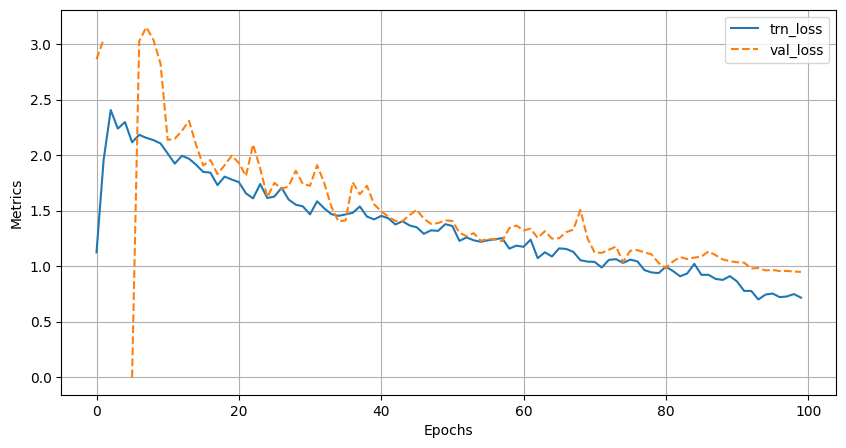

In [53]:
results_file = '/usr/local/lib/python3.10/dist-packages/tests/tmp/runs/detect/yolov8l_custom4/results.csv'
results = pd.read_csv(results_file)

train_loss = results['train/box_loss']
val_loss = results['val/box_loss']

plt.figure(figsize=(10, 5))
plt.plot(train_loss, label='trn_loss')
plt.plot(val_loss, label='val_loss', linestyle='--')
plt.xlabel('Epochs')
plt.ylabel('Metrics')
plt.legend()
plt.grid(True)
plt.show()

In [24]:
model.save(os.getcwd() + '/trained_yolov8.pt')

In [26]:
image = Image.open('/content/applied_computer_vision_project_2/dataset/val/images/book_1.jpg')

avg_time, max_memory = profile_model(model, image)
print(f"Average inference time: {avg_time*1000:.2f} ms")
print(f"Max GPU memory allocated: {max_memory:.2f} MB")


0: 640x640 1 book, 62.6ms
Speed: 2.9ms preprocess, 62.6ms inference, 2.3ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 book, 62.7ms
Speed: 4.1ms preprocess, 62.7ms inference, 1.4ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 book, 35.1ms
Speed: 2.5ms preprocess, 35.1ms inference, 1.4ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 book, 36.4ms
Speed: 2.5ms preprocess, 36.4ms inference, 1.4ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 book, 35.4ms
Speed: 2.5ms preprocess, 35.4ms inference, 1.4ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 book, 34.9ms
Speed: 3.7ms preprocess, 34.9ms inference, 1.7ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 book, 36.5ms
Speed: 2.6ms preprocess, 36.5ms inference, 1.5ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 book, 35.0ms
Speed: 2.5ms preprocess, 35.0ms inference, 1.5ms postprocess per image at shape (1, 3, 640, 640)

0: 640x

In [27]:
def process_image(model, image):
    colors = {
        'laptop': (255, 0, 0),
        'book': (0, 255, 0)
        }

    image_array = np.array(image)

    results = model(image_array)

    for result in results:
        boxes = result.boxes.cpu().numpy()
        for box in boxes:
            r = box.xyxy[0].astype(int)
            label = result.names[int(box.cls)]
            color = colors.get(label.lower(), (255, 255, 255))

            cv2.rectangle(image_array, r[:2], r[2:], color, 2)

            label_size, baseline = cv2.getTextSize(label, cv2.FONT_HERSHEY_SIMPLEX, 0.5, 1)
            top_left = (r[0], r[1] - label_size[1] - baseline)
            bottom_right = (r[0] + label_size[0], r[1])
            cv2.rectangle(image_array, top_left, bottom_right, color, cv2.FILLED)
            cv2.putText(image_array, label, (r[0], r[1] - baseline),
                        cv2.FONT_HERSHEY_SIMPLEX, 0.5, (0, 0, 0), 1)

    return Image.fromarray(image_array)


0: 448x640 1 laptop, 49.7ms
Speed: 1.6ms preprocess, 49.7ms inference, 1.6ms postprocess per image at shape (1, 3, 448, 640)


<ipython-input-27-73d370c377bd>:24: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  label = result.names[int(box.cls)]


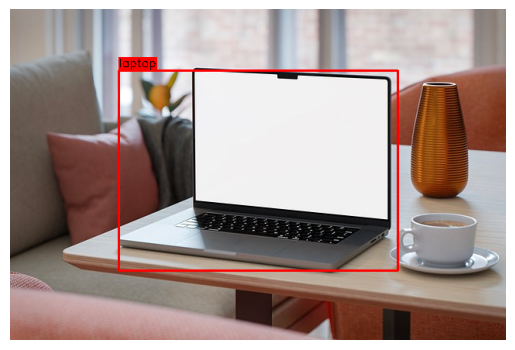


0: 448x640 1 book, 49.7ms
Speed: 2.2ms preprocess, 49.7ms inference, 1.6ms postprocess per image at shape (1, 3, 448, 640)


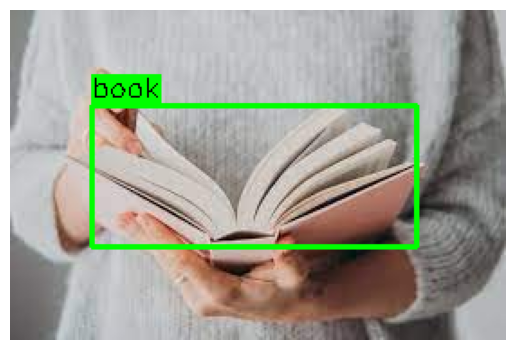


0: 320x640 (no detections), 38.8ms
Speed: 2.2ms preprocess, 38.8ms inference, 0.6ms postprocess per image at shape (1, 3, 320, 640)


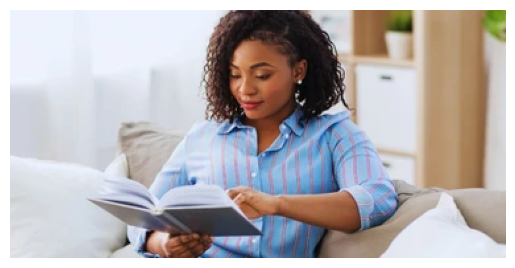


0: 448x640 2 laptops, 51.1ms
Speed: 1.7ms preprocess, 51.1ms inference, 1.6ms postprocess per image at shape (1, 3, 448, 640)


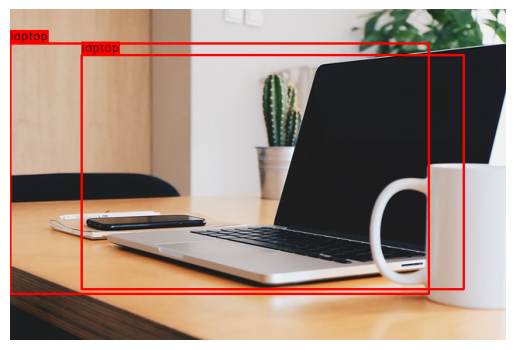


0: 448x640 (no detections), 48.6ms
Speed: 2.6ms preprocess, 48.6ms inference, 0.8ms postprocess per image at shape (1, 3, 448, 640)


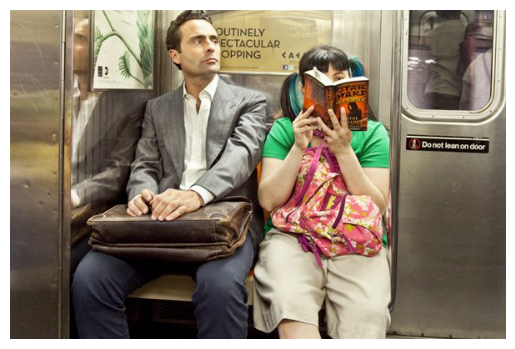


0: 448x640 1 laptop, 48.6ms
Speed: 1.5ms preprocess, 48.6ms inference, 1.6ms postprocess per image at shape (1, 3, 448, 640)


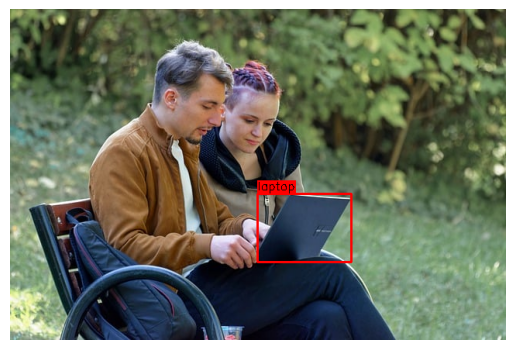

In [40]:
image_folder = os.getcwd() + "/applied_computer_vision_project_2/dataset/val/images"

image_files = [f for f in os.listdir(image_folder) if f.lower().endswith(('.png', '.jpg', '.jpeg', '.gif'))]
random.shuffle(image_files)
processed_images = 0

for image_file in image_files:
    image_path = os.path.join(image_folder, image_file)
    try:
        with Image.open(image_path) as img:
            fig, ax = plt.subplots(1)
            img = process_image(model, img)

            ax.imshow(img)
            ax.axis('off')
            plt.show()
            if processed_images == 5:
                break
            processed_images += 1
    except IOError:
        print(f"Error opening {image_file}")
